# Calculating GB energy from DF

## Objective

(i) Select data from boundaries
(ii) Organize it for all grains
(iii) Calculate the energy with wield

## Method

    * Open Dataframe
    * Select attributes of interest from boundaries
    * Create a new DF with grain information
    * Convert data to wield
    * Run wield for all grains
    * Store energy in Dataframe

In [1]:
import pandas as pd
import numpy as np
from skimage import draw,io
from skimage.segmentation import flood, flood_fill

from matplotlib import pyplot as plt


### Open Dataframe


In [2]:

folder = "../data/"
file = "1_001"
path = folder + file

#%%

sample = np.loadtxt(path+ ".txt")

'''
# Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
# Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
# Column 7:     Misorientation Angle
# Column 8-10:  Misorientation Axis in Right Hand grain
# Column 11-13: Misorientation Axis in Left Hand grain
# Column 14:    length (in microns)
# Column 15:    trace angle (in degrees)
# Column 16-19: x,y coordinates of endpoints (in microns)
# Column 20-21: IDs of right hand and left hand grains

'''


df = pd.DataFrame(  data = sample, 
                    columns = ["right_phi1","right_PHI","right_phi2",                 #1-3
                               "left_phi1","left_PHI","left_phi2",                    #4-6 
                               "ori_angle",                                           #7
                               "right_ori_x","right_ori_y","right_ori_z",              #8-10
                               "left_ori_x","left_ori_y","left_ori_z",                 #11-13  
                               "length",                                              #14
                               "trace_angle",                                         #15
                               "x_start", "y_start", "x_end", "y_end",                #16-19
                               "grain_right","grain_left"                             #20-21
                               ]                    
                 )


In [3]:
df.grain_right.drop_duplicates(keep = False)

3        149.0
6        216.0
7        264.0
9        286.0
12       381.0
         ...  
3918    1229.0
3926    2569.0
3929     291.0
3931     495.0
3933     604.0
Name: grain_right, Length: 250, dtype: float64

### Select attributes of interest from boundaries

The group of information that is directly related to the grain: 
* Column 1-3:   right hand average orientation (phi1, PHI, phi2 in radians)
* Column 4-6:   left hand average orientation (phi1, PHI, phi2 in radians)
* Column 7:     Misorientation Angle
* Column 8-10:  Misorientation Axis in Right Hand grain
* Column 11-13: Misorientation Axis in Left Hand grain
* Column 20-21: IDs of right hand and left hand grains

The Columns 20-21 describe the grain of interest

The Columns 1-6 depends on grain itself, **here we are interested**

The Columns 7-13 depends on left and right grains

In [4]:
#df_left = df[['ori_angle','left_phi1','left_PHI','left_phi2','left_ori_x','left_ori_y','left_ori_z','grain_left']]
#df_right = df[['right_phi1','right_PHI','right_phi2','right_ori_x','right_ori_y','right_ori_z','grain_right']]

# left_ori is related with other grain, than is not interesting to keep in this case

df_left = df[['left_phi1','left_PHI','left_phi2','grain_left']]
df_left = df_left.rename(columns={"grain_left": "grain"})


df_right = df[['right_phi1','right_PHI','right_phi2','grain_right']]
df_right = df_right.rename(columns={"grain_right": "grain"})


In [5]:
df_left = df_left[~df_left.grain.duplicated()].sort_values('grain')
df_left = df_left.set_index('grain')


In [6]:
df_right = df_right[~df_right.grain.duplicated()].sort_values('grain')
df_right = df_right.set_index('grain')


In [7]:
#df_grains = pd.concat([df_left,df_right])
df_grains = df_left.join(df_right)

In [8]:
df_grains.sort_values('grain')

,left_phi1,left_PHI,left_phi2,right_phi1,right_PHI,right_phi2
grain,,,,,,
1.0,5.039,0.678,1.946,5.039,0.678,1.946
2.0,0.241,0.410,6.087,0.241,0.410,6.087
3.0,0.259,0.637,6.253,0.259,0.637,6.253
4.0,4.502,0.759,1.253,4.502,0.759,1.253
5.0,4.443,0.631,1.231,4.443,0.631,1.231
...,...,...,...,...,...,...
2785.0,2.677,0.281,3.545,2.677,0.281,3.545
2786.0,6.142,0.384,0.133,6.142,0.384,0.133
2788.0,0.027,0.126,6.158,0.027,0.126,6.158


In [25]:
df_grains.isnull().sum()

left_phi1      0
left_PHI       0
left_phi2      0
right_phi1    51
right_PHI     51
right_phi2    51
dtype: int64

## Fill Grains based on phi1, PHI, and phi2

In [9]:
df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())

In [10]:
grain = 123

One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
One_grain

,right_phi1,right_PHI,right_phi2,left_phi1,left_PHI,left_phi2,ori_angle,right_ori_x,right_ori_y,right_ori_z,...,left_ori_y,left_ori_z,length,trace_angle,x_start,y_start,x_end,y_end,grain_right,grain_left
2719,3.555,0.628,2.500,1.606,0.615,4.167,35.30,-4.0,27.0,9.0,...,27.0,9.0,7.211,133.9,684.0,42.72,689.0,47.92,126.0,123.0
2720,1.606,0.615,4.167,2.762,0.090,3.450,40.77,-3.0,16.0,-11.0,...,16.0,-11.0,3.055,49.1,684.0,42.72,686.0,40.41,123.0,49.0
2731,5.740,0.747,1.131,1.606,0.615,4.167,30.37,-9.0,11.0,1.0,...,11.0,1.0,3.055,169.1,686.0,40.41,689.0,40.99,93.0,123.0
2748,1.606,0.615,4.167,5.435,0.578,0.166,49.78,13.0,9.0,10.0,...,9.0,10.0,6.429,98.9,689.0,40.99,690.0,47.34,123.0,109.0
2752,4.935,0.747,1.994,1.606,0.615,4.167,52.88,23.0,1.0,19.0,...,1.0,19.0,1.155,30.0,689.0,47.92,690.0,47.34,134.0,123.0


In [11]:
grain_info = df_grains_norm.loc[grain,:]
grain_info

left_phi1     0.254902
left_PHI      0.586603
left_phi2     0.662950
right_phi1    0.254902
right_PHI     0.586603
right_phi2    0.662950
Name: 123.0, dtype: float64

In [12]:

width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

width,height

(691, 48)

In [13]:
x_center = int(One_grain[['x_start','x_end']].mean().mean())
y_center = int(One_grain[['y_start','y_end']].mean().mean())

In [14]:
One_grain.y_start.iloc[1:3]

2720    42.72
2731    40.41
Name: y_start, dtype: float64

The method polygon_fill do not work because it uses the Even–odd rule and fill all closed paths based on directions provided as parameters. As the order or parameters meters and in our case is not ordered, this method is not helpful.


## Flood Fill method

In [42]:

np_img = np.zeros([height, width, 3])

for idx, row in One_grain.iterrows():
   # print("%d %d %d %d\n" %(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16")))
    #rr,cc = draw.polygon(One_grain.x_start, One_grain.y_start, np_img.shape)
    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    np_img[cc,rr,:3] = (1,1,1)
    
#mask = flood_fill(np_img, (50, 52,1), 255 )
mask = flood(np_img, (y_center, x_center,0))
#np_img = flood_fill(np_img, (50, 52,0), 155 )
np.shape(mask[:,:,1])



(1048, 191)

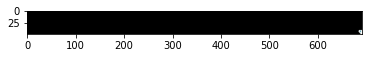

In [16]:
phi1,Phi,phi2 = grain_info[["right_phi1","right_PHI","right_phi2"]]
np_img[mask[:,:,1]] = [phi1,Phi,phi2]
phi1,Phi,phi2

plt.imshow(np_img)

Flood method works when used as a mask and apply in the original image.

Applying to all grains

In [17]:
from IPython.display import set_matplotlib_formats
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [44]:
width = int(max([max(df.x_end),max(df.x_start)]))+1
height = int(max([max(df.y_end),max(df.y_start)]))+1
np_img = np.zeros([height, width, 3])

for idx, row in df.iterrows():
    rr,cc,a = draw.line_aa(row.x_start.astype("uint16"),row.y_start.astype("uint16"),row.x_end.astype("uint16"),row.y_end.astype("uint16"))
    np_img[cc,rr,:3] = (1,1,1)
    
#plt.imshow(np_img)


In [27]:
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 18.3 s, sys: 3.44 s, total: 21.7 s
Wall time: 21.7 s


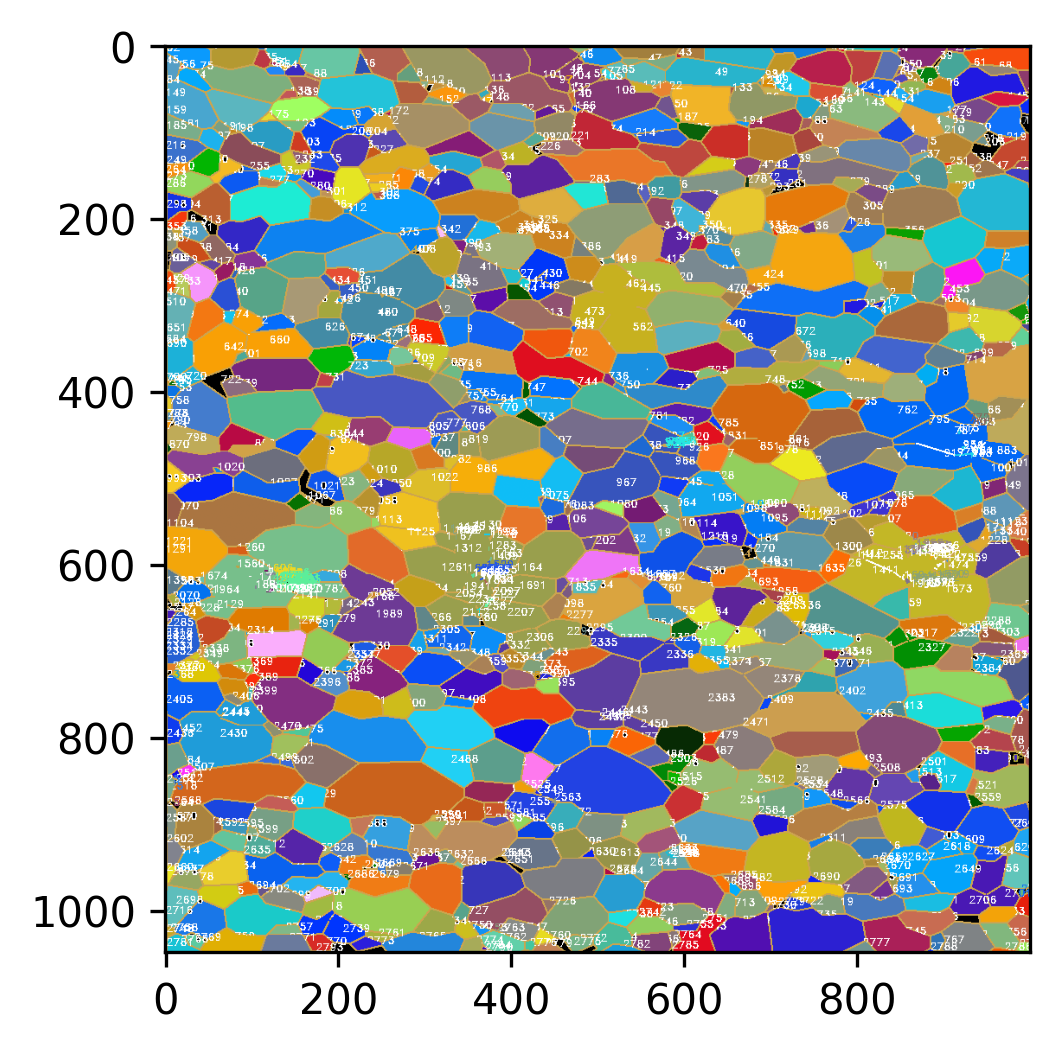

In [45]:
%%time
for grain in df_grains.index:
    df_grains_norm = (df_grains - df_grains.min()) / (df_grains.max() - df_grains.min())
    One_grain = df[(df["grain_right"] == grain) | (df["grain_left"] == grain)]
    grain_info = df_grains_norm.loc[grain,:]


    width = int(max([max(One_grain.x_end),max(One_grain.x_start)]))+1
    height = int(max([max(One_grain.y_end),max(One_grain.y_start)]))+1

    x_center = int(One_grain[['x_start','x_end']].mean().mean())
    y_center = int(One_grain[['y_start','y_end']].mean().mean())



    mask = flood(np_img, (y_center, x_center,0))
    phi1,Phi,phi2 = grain_info[["left_phi1","left_PHI","left_phi2"]]
    #cv2.putText(np_img, text=str(int(grain)), org=(x_center,y_center),fontFace=2, fontScale=0.4, color=(255,255,255), thickness=1)
    np_img[mask[:,:,1]] = [phi1,Phi,phi2]

plt.imshow(np_img)
#io.imsave("processing/"+ file +'.png',np_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


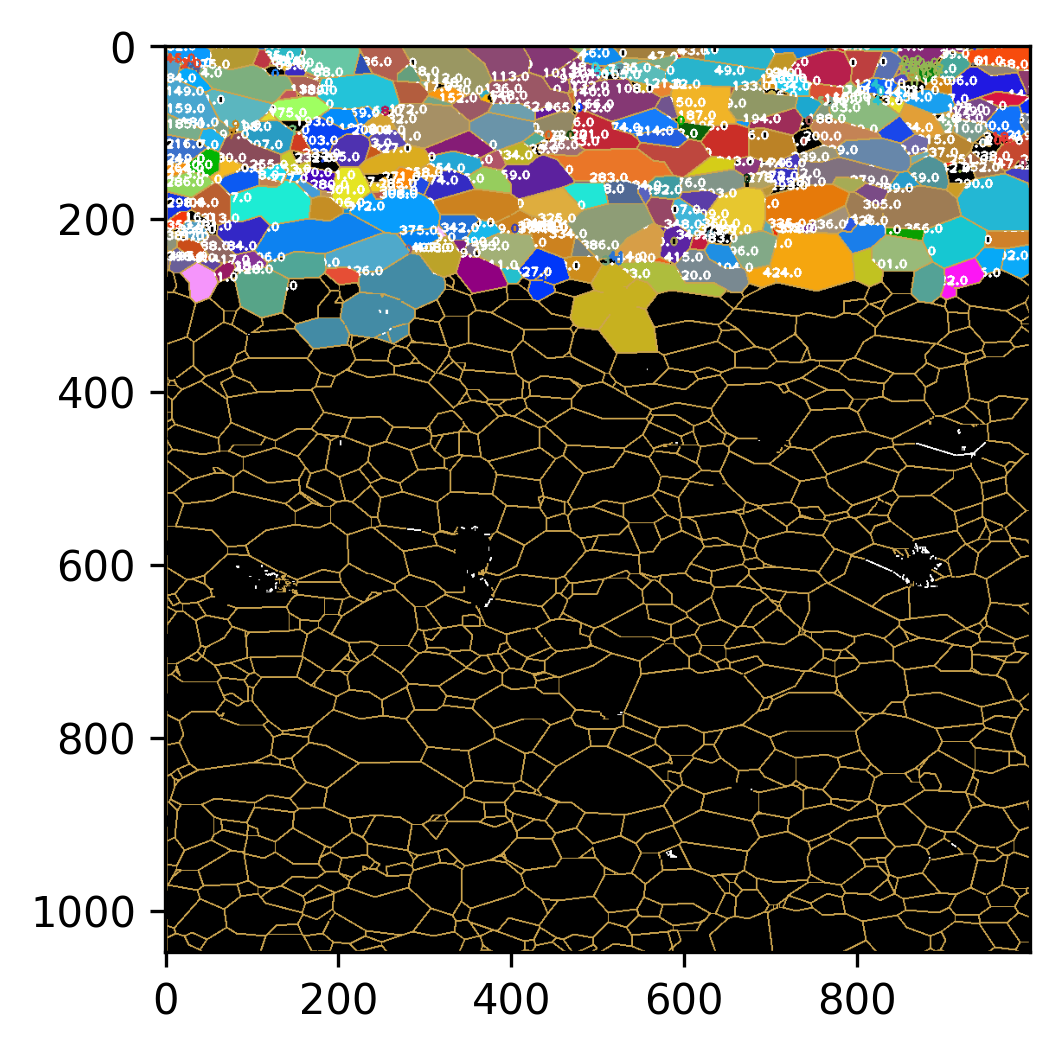

In [38]:
plt.imshow(np_img)

In [21]:
not(any(grain_info[["right_phi1","right_PHI","right_phi2"]]))

False

In [22]:
io.imsave("processing/"+ file +'.png',np_img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
